In [1]:
import matplotlib.pyplot as plt
from itertools import product
import slycot as sly
import numpy as np
import control as ct
import rpc_diism.robust as rb

In [2]:
# Plant P
den = [0.2, 1.2, 1]
P = ct.tf([2,1], den)
display("Plant transfer function", P)

# Closed loop to be matched
wn = 5
zeta = 0.7
denM = [1/wn/wn, 2*zeta/wn, 1]
M = ct.tf([1], denM)
display("Reference transfer function", M)

'Plant transfer function'

TransferFunction(
array([2, 1]),
array([0.2, 1.2, 1. ]),
outputs=1, inputs=1)

'Reference transfer function'

TransferFunction(
array([1]),
array([0.04, 0.28, 1.  ]),
outputs=1, inputs=1)

Define performance weight and uncertainty weight 

In [3]:
# Uncertainty block weight Wi
Mi = 4
ei = 1e-4
wbi = 1 # Crossover frequency
Wi = ct.ss(rb.weightU(wbi, Mi, ei, 1))

# Model matching weight Wm 
Mm = 0.1
em = 1e-4
wb = 2*wn # Crossover frequency
Wm = ct.ss(rb.weightS(wb, Mm, em, 1))

Construct the LFT

In [4]:
Wi.input_labels = ['u[0]']
Wi.output_labels = ['zdelta[0]']
Wm.input_labels = ['q[0]']
Wm.output_labels = ['z[0]']
P.input_labels = ['u[0]']
P.output_labels = ['yp[0]']
M.input_labels = ['r[0]']
M.output_labels = ['v[0]']

# Summing junction to ybar (additive uncertainty)
sumdelta = ct.summing_junction(inputs=['yp','wdelta'], output='ybar', dimension=1)

# Feedback: y = r-ybar
fbk = ct.summing_junction(inputs=['r','-ybar'], output='y', dimension=1)

# Model matching summing junction
Msj = ct.summing_junction(inputs=['ybar','-v'], output='q', dimension=1)

# Generate the G transfer function of the LFT
G = ct.minreal(ct.interconnect([P, M, Wi, Wm, sumdelta, fbk, Msj],
                    inputs=['wdelta[0]','r[0]','u[0]'],
                    outputs=['zdelta[0]','z[0]','y[0]']), 
                    verbose=False)

Do $\mu$-synthesis.

In [5]:
# Controller I/O sizes
f = 1

# Extended uncertainty structure: a 2x2 uncertainty block and a 2x2 performance block
nblock = np.array([1,1])
# This has to be == 2 (complex uncertainty) for each block (other values are not implemented)
itype = np.array([2,2])

# Frequency range for mu computations
omega = np.logspace(-3, 3, 101)

# Do mu-synthesis via D-K iteration
K, best_nubar, init_mubar, best_mubar, gamma = rb.musyn(G, f, nblock, itype, omega, reduce=0, initgamma=1e2)
#order = 8
#K = ct.balred(K, order, method='truncate')


display("Best upper bound (nubar) to mu norm of Tzw_delta: ", best_nubar)

Infinity norm of Tzw_delta with initial Hinfinity controller:  10.746730877348233
Iteration # 1
Best upper bound to mu norm of Tzw_delta:  8.201013365508315
Iteration # 2
Best upper bound to mu norm of Tzw_delta:  5.761059134097597
Iteration # 3
No better upper bound to mu norm of Tzw_delta found: trying D order  4 qutol  2
Iteration # 4
No better upper bound to mu norm of Tzw_delta found: trying D order  4 qutol  3
Iteration # 5
No better upper bound to mu norm of Tzw_delta found: trying D order  4 qutol  4
Iteration # 6
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  1
Iteration # 7
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  2
Iteration # 8
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  3
Iteration # 9
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  4
Iteration # 10
No better upper bound to mu norm of Tzw_delta found: trying D order  6 qutol  1


'Best upper bound (nubar) to mu norm of Tzw_delta: '

5.761059134097597

Text(0.5, 1.0, 'Initial and final $\\bar\\mu$')

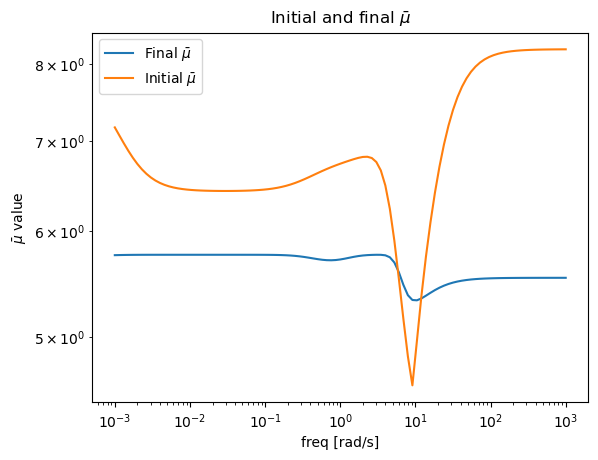

In [6]:
plt.loglog(omega, best_mubar, label=r'Final $\bar \mu$')
plt.loglog(omega, init_mubar, label=r'Initial $\bar \mu$')
plt.ylabel(r'$\bar\mu$ value')
plt.xlabel('freq [rad/s]')
plt.legend()
plt.title(r'Initial and final $\bar\mu$')

Text(0.5, 1.0, 'Singular values of T for the nominal system')

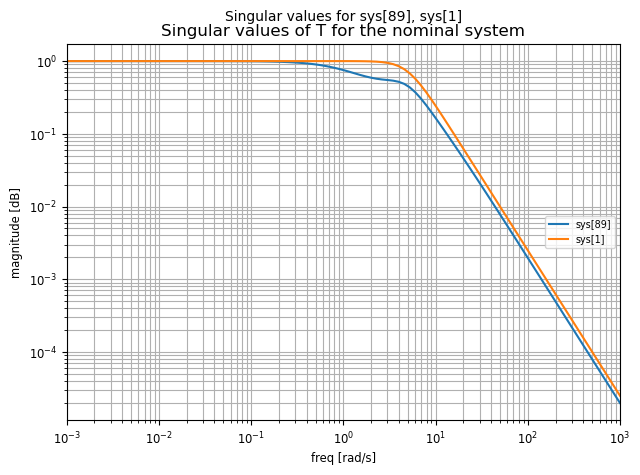

In [7]:
# Compute sensitivity for the nominal system
I = ct.ss([], [], [], np.eye(1)) # Identity system  
Delta = 0 * I
Delta.input_labels = ['zdelta[0]']
Delta.output_labels = ['wdelta[0]']               
K.input_labels = ['y[0]']
K.output_labels = ['u[0]'] 

T = ct.minreal(ct.interconnect([P, Delta, K, Wi, Wm, sumdelta, fbk],
                    inputs=['r[0]'],
                    outputs=['ybar[0]'], check_unused=False), verbose=False)


ct.freqplot.singular_values_plot(T, omega);
ct.freqplot.singular_values_plot(M, omega);
plt.ylabel('magnitude [dB]')
plt.xlim([1e-3, 1e3])
plt.xlabel('freq [rad/s]')
plt.title('Singular values of T for the nominal system')

Text(0.5, 1.0, 'Singular values of T for the nominal system')

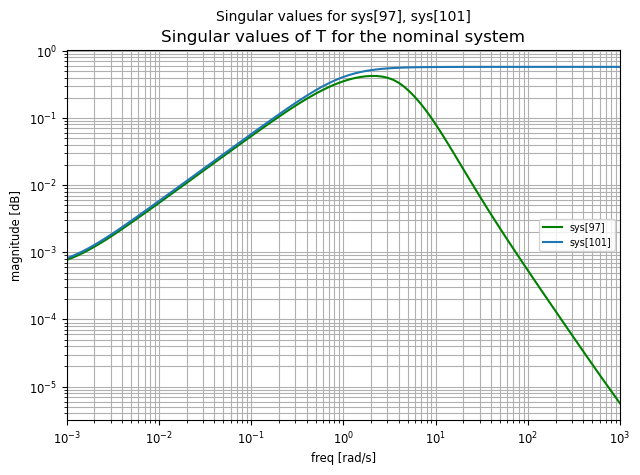

In [8]:
ct.freqplot.singular_values_plot((T-M), omega, color='g');
ct.freqplot.singular_values_plot(rb.invss(Wm)*best_nubar, omega);
plt.ylabel('magnitude [dB]')
plt.xlim([1e-3, 1e3])
plt.xlabel('freq [rad/s]')
plt.title('Singular values of T for the nominal system')

Verify the performance under a "random" perturbation satisfying the bound $\|\Delta\|_\infty = 1/ \bar\nu$ for $\bar\nu=\sup_\omega \bar\mu$. It must hold that $\|W_e S\|_\infty \leq\bar\nu$.

Text(0.5, 1.0, 'Singular values of T for the perturbed system')

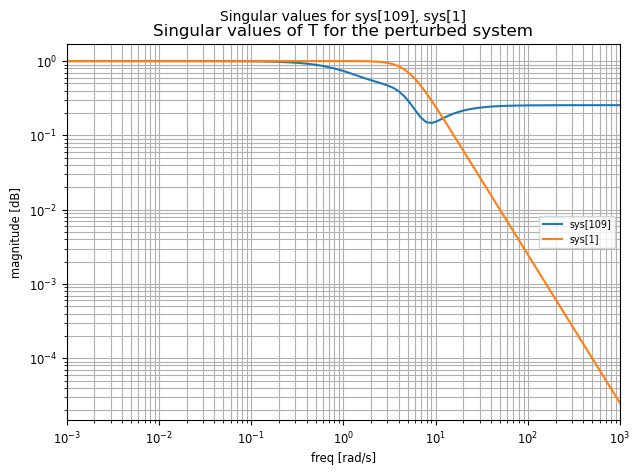

In [9]:
# Generate a perturbation with norm equal to 1/best_nubar
Delta = 1/best_nubar * I
Delta.input_labels = ['zdelta[0]']
Delta.output_labels = ['wdelta[0]'] 


T = ct.minreal(ct.interconnect([P, Delta, K, Wi, Wm, sumdelta, fbk],
                    inputs=['r[0]'],
                    outputs=['ybar[0]'], check_unused=False), verbose=False)

ct.freqplot.singular_values_plot(T, omega);
ct.freqplot.singular_values_plot(M, omega);
plt.ylabel('magnitude [dB]')
plt.xlim([1e-3, 1e3])
plt.xlabel('freq [rad/s]')
plt.title('Singular values of T for the perturbed system')

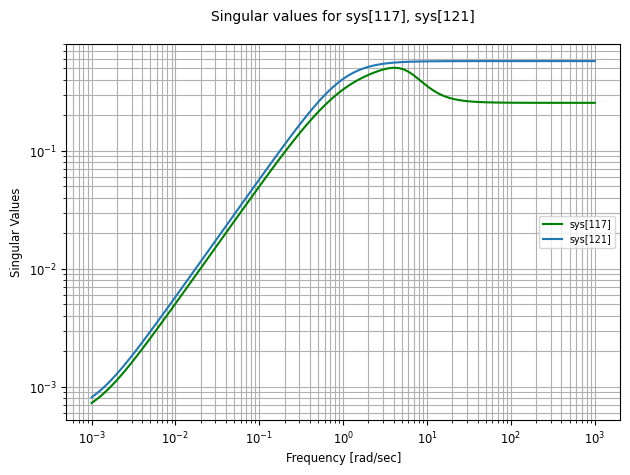

In [10]:
ct.freqplot.singular_values_plot((T-M), omega, color='g');
ct.freqplot.singular_values_plot(rb.invss(Wm)*best_nubar, omega);